## ==========================================================
## You should first upload tree_regularization.py and DataLoader.py in the left control bar
## ==========================================================

## Download and preprocess dataset

In [1]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file = '1Nl59uCt3SeCMH891nwS6I3vJbDrVKXQm' #-- Updated File ID 
file2 = '1JIw9Kc2K7W_sJaMoZOavGicuf7qrPFBr'
file3 = '1-P6lzpwyXxet37NwJCNhxm_dwZ22Gm42'

    100% |████████████████████████████████| 993kB 20.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


## You need to click the link and get the authorization of Google drive in the box above

Dataset unzip

In [0]:
downloaded = drive.CreateFile({'id': file})
downloaded.GetContentFile('zip.zip') 
!unzip -q 'zip.zip'
downloaded = drive.CreateFile({'id': file2})
downloaded.GetContentFile('zip.zip') 
!unzip -q 'zip.zip'
downloaded = drive.CreateFile({'id': file3})
downloaded.GetContentFile('zip.zip') 
!unzip -q 'zip.zip'

Set custom dataset path

In [0]:
cpu_contention_path = 'cpu_contention/'
input_rate_path = 'labeled_process_A/input_rate/'
node_failure_path = 'labeled_process_A/node_failure/'

Loading data for 3 different abnormal types

In [5]:
from DataLoader import DataLoader
abnormal_cpu_contention, abnormal_input_rate, abnormal_node_failure, normal_cpu_contention, normal_input_rate, normal_node_failure = DataLoader(cpu_contention_path, input_rate_path, node_failure_path)

/content/DataLoader.py:31: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  abnormal_cpu_contention = abnormal_cpu_contention.reindex_axis(header, axis=1)
/content/DataLoader.py:33: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  normal_cpu_contention = normal_cpu_contention.reindex_axis(header, axis=1)
/content/DataLoader.py:45: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  abnormal_input_rate = abnormal_input_rate.reindex_axis(header, axis=1)
/content/DataLoader.py:47: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  normal_input_rate = normal_input_rate.reindex_axis(header, axis=1)
/content/DataLoader.py:59: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  abnormal_node

Get samples for each abnormal type and normal type

In [0]:

import pandas as pd
import numpy as np
abnormal = pd.concat((abnormal_cpu_contention.sample(n=2500), abnormal_input_rate.sample(n=2500), abnormal_node_failure))
normal = pd.concat((normal_cpu_contention.sample(n=2500), normal_input_rate.sample(n=2500), normal_node_failure.sample(n=2500)))

abnormal = abnormal.sample(frac=1)
normal = normal.sample(frac=1)


Uncomment to set only two labels "normal" and "abnormal"

In [0]:
abnormal['label'] = 'abnormal'

Get custom data proportion

In [0]:
df_test = pd.concat((abnormal.iloc[:250, :], normal.iloc[5000:7500, :]))
df = pd.concat((abnormal.iloc[500:4500, :], normal.iloc[:4000, :]))

Shuffle and fill Nan value

In [0]:
df = df.sample(frac=1)
df = df.fillna(value = 0)
df_test = df_test.fillna(value = 0)

Encode categories into numbers

In [10]:
cat = set(df['label'])
cat_index = dict(zip(cat, range(len(cat))))
index_cat = dict(zip(range(len(cat)), cat))
cat_index

{'abnormal': 0, 'normal': 1}

{'abnormal': 0, 'normal': 1}

Release RAM space

In [11]:
import gc
del abnormal_cpu_contention, abnormal_input_rate, abnormal_node_failure
gc.collect()

47

47

Drop columns "t", "comment" and "label"

In [0]:
Y = np.array(df['label'].map(lambda x: cat_index[x]))
df = df.drop(['t', 'label', 'comment'], axis=1)
Y_test = np.array(df_test['label'].map(lambda x: cat_index[x]))
df_test = df_test.drop(['t', 'label', 'comment'], axis=1)

Value scaling

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(df)
X_test = scaler.transform(df_test)

Uncomment to use RandomOverSampler

* If we don't use this and our training set is not blance, our model is going to "cheat" --- Always predicting normal to get good score

In [0]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X, Y = ros.fit_resample(X, Y)

Transform to one hot vectors

In [0]:
Y = np.eye(len(cat))[Y.reshape(-1)]
Y_test = np.eye(len(cat))[Y_test.reshape(-1)]

In [15]:
len(X_test)

2750

2750

## Tree regularization

class TreeMLP(in_count, out_count, hidden_sizes, strength)

in_count: input shape

out_count: output shape

hidden_sizes: surrogate network's structure

strength: regularization strengh

APL_mode: 

0 - implemented by paper's source code

1 - implemented by its definition

In [0]:
from tree_regularization import *
APL_mode = 0
t = TreeMLP(X.shape[1], len(cat), [20, 50, 50, 50], strength=0.01, APL_mode=APL_mode)

For the next cell, the tree regularization network will take at least 1 hour to get stable prediction

In [64]:
t.train(X, Y, batch_size=128, iters_retrain=5, epochs_sur=20, epochs_mlp=4, feature_names=list(df.columns.values), validation_data=(X_test, Y_test), class_names=list(cat_index.keys()))

training MLP net... [1/3]
Train on 8000 samples, validate on 2750 samples
Epoch 1/10
8000/8000 [==============================] - 3s 360us/step - loss: 0.7039 - acc: 0.5042 - val_loss: 0.7629 - val_acc: 0.0909
Epoch 2/10
8000/8000 [==============================] - 1s 77us/step - loss: 0.6889 - acc: 0.5970 - val_loss: 0.6883 - val_acc: 0.6360
Epoch 3/10
8000/8000 [==============================] - 1s 74us/step - loss: 0.5699 - acc: 0.7622 - val_loss: 0.3637 - val_acc: 0.9062
Epoch 4/10
8000/8000 [==============================] - 1s 74us/step - loss: 0.4193 - acc: 0.8366 - val_loss: 0.3437 - val_acc: 0.9004
Epoch 5/10
8000/8000 [==============================] - 1s 74us/step - loss: 0.3867 - acc: 0.8574 - val_loss: 0.3863 - val_acc: 0.8807
Epoch 6/10
8000/8000 [==============================] - 1s 79us/step - loss: 0.3572 - acc: 0.8718 - val_loss: 0.3016 - val_acc: 0.9120
Epoch 7/10
8000/8000 [==============================] - 1s 78us/step - loss: 0.3510 - acc: 0.8749 - val_loss: 0.378

KeyboardInterrupt: ignored

# Draw the figure

In [0]:
def get_points(path):
    try:
        f = open(path + 'log.txt', 'rb')
    except:
        return [], []
    fs = f.readlines()
    APL = []
    acc = []
    for l in fs:
        l = l.decode("utf-8").strip()
        if float(l.split(' ')[-1]) > 60:
          continue
        APL.append(float(l.split(' ')[-1]))
        acc.append(float(l.split(';')[0].split(' ')[-1]))
        
    APL, acc = np.array(APL)[np.argsort(APL)], np.array(acc)[np.argsort(APL)]
    
    return APL, acc
  
def drawtest(t=''):
    path_n = t + 'tree_n/'
    path_t = t + 'tree_t/'
    path_l2 = t + 'tree_l2/'
    path_l1 = t + 'tree_l1/'
    apl_n, acc_n = get_points(path_n)
    apl_t, acc_t = get_points(path_t)
    apl_l2, acc_l2 = get_points(path_l2)
    apl_l1, acc_l1 = get_points(path_l1)
    %matplotlib inline
    fig = plt.figure(figsize =(8, 5), dpi=100, facecolor="white")
    font={'family': 'serif', 'color':'darkred', 'weight':'normal', 'size':16} 
    ax = plt.gca()
    plt.plot(apl_n, acc_n, c='b') 
    plt.plot(apl_t, acc_t, c='y') 
    plt.plot(apl_l2, acc_l2, c='r') 
    plt.plot(apl_l1, acc_l1, c='g') 
    plt.legend(["Decision Tree", "Tree Regularization", "l2 Regularization", "l1 Regularization"]) 
    plt.xlabel("APL", font)
    plt.ylabel("Accuracy", font)

 ## Get samples from tree regularization network

In [65]:
name = 't'
# y_train_hat
y_train_hat = t.predict(X)
y_pred = [np.argmax(x) for x in y_train_hat]
l = [1,2,3,4,5,6,7,8,9,10] + [12, 14, 16, 18, 20] + [25, 30, 40, 50, 80, 120, 160, 200, 250, 300, 350, 400, 500, 800, 1000, 2000, 2500, 3000]
for i in range(len(l)):
  tree = DecisionTreeClassifier(min_samples_leaf=l[i])
  tree.fit(X, y_pred)
  if not os.path.isdir('./tree_'+name):
    os.mkdir('./tree_'+name)
  nodes = visualize(tree, './tree_'+name+'/tree' + str(i) + '.pdf',False,list(df.columns.values), class_names=list(cat_index.keys()))
  acc = accuracy_score(tree.predict(X_test), [np.argmax(x) for x in Y_test])
  leaf_indices = tree.apply(X)
  leaf_counts = np.bincount(leaf_indices)
  leaf_i = np.arange(tree.tree_.node_count)
  apl = np.dot(leaf_i, leaf_counts) / float(X.shape[0])
  if APL_mode == 1:
    apl = np.sum(tree.decision_path(X)) / float(X.shape[0])
  print('tree'+ str(i) + ': accuracy {:.5f}; number of nodes '.format(acc) + str(nodes) + '; APL {:.2f}'.format(apl))
  log = open('./tree_'+name+'/log.txt', 'a')
  log.write('tree'+ str(i) + ': accuracy {:.5f}; number of nodes '.format(acc) + str(nodes) + '; APL {:.2f}\n'.format(apl))
  log.close()

tree0: accuracy 0.84036; number of nodes 554; APL 301.75
tree1: accuracy 0.82873; number of nodes 486; APL 270.13
tree2: accuracy 0.83745; number of nodes 450; APL 250.90
tree3: accuracy 0.83782; number of nodes 392; APL 220.27
tree4: accuracy 0.84182; number of nodes 364; APL 205.36
tree5: accuracy 0.84109; number of nodes 330; APL 184.90
tree6: accuracy 0.84400; number of nodes 314; APL 173.97
tree7: accuracy 0.84400; number of nodes 296; APL 164.96
tree8: accuracy 0.84800; number of nodes 292; APL 163.42
tree9: accuracy 0.83782; number of nodes 288; APL 160.23
tree10: accuracy 0.84327; number of nodes 262; APL 146.44
tree11: accuracy 0.84400; number of nodes 236; APL 127.63
tree12: accuracy 0.85636; number of nodes 222; APL 121.18
tree13: accuracy 0.84909; number of nodes 206; APL 111.30
tree14: accuracy 0.84945; number of nodes 202; APL 108.51
tree15: accuracy 0.85564; number of nodes 178; APL 97.20
tree16: accuracy 0.85964; number of nodes 164; APL 89.49
tree17: accuracy 0.84545; 

## Get samples from Decision Tree

In [46]:
name = 'n'
#y_train_hat
y_pred = [np.argmax(x) for x in Y]
l = [1,2,3,4,5,6,7,8,9,10] + [12, 14, 16, 18, 20] + [25, 30, 40, 50, 80, 120, 160, 200, 250, 300, 350, 400, 500, 800, 1000, 2000, 2500, 3000]
for i in range(len(l)):
  tree = DecisionTreeClassifier(min_samples_leaf=l[i])
  tree.fit(X, y_pred)
  if not os.path.isdir('./tree_'+name):
    os.mkdir('./tree_'+name)
  nodes = visualize(tree, './tree_'+name+'/tree' + str(i) + '.pdf',False,list(df.columns.values), class_names=list(cat_index.keys()))
  acc = accuracy_score(tree.predict(X_test), [np.argmax(x) for x in Y_test])
  leaf_indices = tree.apply(X)
  leaf_counts = np.bincount(leaf_indices)
  leaf_i = np.arange(tree.tree_.node_count)
  apl = np.dot(leaf_i, leaf_counts) / float(X.shape[0])
  if APL_mode == 1:
    apl = np.sum(tree.decision_path(X)) / float(X.shape[0])
  print('tree'+ str(i) + ': accuracy {:.5f}; number of nodes '.format(acc) + str(nodes) + '; APL {:.2f}\n'.format(apl))
  log = open('./tree_'+name+'/log.txt', 'a')
  log.write('tree'+ str(i) + ': accuracy {:.5f}; number of nodes '.format(acc) + str(nodes) + '; APL {:.2f}\n'.format(apl))
  log.close()

number of nodes: 198
tree0: accuracy 0.98036; number of nodes 198; APL 121.41

number of nodes: 188
tree1: accuracy 0.97927; number of nodes 188; APL 115.87

number of nodes: 178
tree2: accuracy 0.98218; number of nodes 178; APL 109.87

number of nodes: 166
tree3: accuracy 0.98400; number of nodes 166; APL 103.83

number of nodes: 158
tree4: accuracy 0.98400; number of nodes 158; APL 98.65

number of nodes: 154
tree5: accuracy 0.98473; number of nodes 154; APL 96.38

number of nodes: 154
tree6: accuracy 0.98473; number of nodes 154; APL 97.03

number of nodes: 154
tree7: accuracy 0.98109; number of nodes 154; APL 95.28

number of nodes: 144
tree8: accuracy 0.98145; number of nodes 144; APL 90.43

number of nodes: 144
tree9: accuracy 0.98182; number of nodes 144; APL 90.42

number of nodes: 138
tree10: accuracy 0.97782; number of nodes 138; APL 85.70

number of nodes: 134
tree11: accuracy 0.97527; number of nodes 134; APL 83.21

number of nodes: 134
tree12: accuracy 0.97309; number of n

## Get samples from l1, l2 regularization network

In [0]:
from tree_regularization import *

In [57]:
t_l1 = L1MLP(X.shape[1], len(cat), [20, 50, 50, 50], strength=0.01, APL_mode=APL_mode)
t_l1.train(X, Y, batch_size=128, iters_retrain=5, epochs_sur=20, epochs_mlp=10, feature_names=list(df.columns.values), validation_data=(X_test, Y_test), class_names=list(cat_index.keys()))

training MLP net... [1/3]
Train on 8000 samples, validate on 2750 samples
Epoch 1/10
8000/8000 [==============================] - 2s 236us/step - loss: 0.7102 - acc: 0.4950 - val_loss: 0.7519 - val_acc: 0.0909
Epoch 2/10
8000/8000 [==============================] - 1s 72us/step - loss: 0.6990 - acc: 0.5457 - val_loss: 0.7101 - val_acc: 0.4218
Epoch 3/10
8000/8000 [==============================] - 1s 70us/step - loss: 0.5955 - acc: 0.7439 - val_loss: 0.4030 - val_acc: 0.8804
Epoch 4/10
8000/8000 [==============================] - 1s 70us/step - loss: 0.4280 - acc: 0.8383 - val_loss: 0.3298 - val_acc: 0.9131
Epoch 5/10
8000/8000 [==============================] - 1s 72us/step - loss: 0.4080 - acc: 0.8498 - val_loss: 0.3803 - val_acc: 0.8807
Epoch 6/10
8000/8000 [==============================] - 1s 73us/step - loss: 0.3767 - acc: 0.8695 - val_loss: 0.3667 - val_acc: 0.8956
Epoch 7/10
8000/8000 [==============================] - 1s 71us/step - loss: 0.3564 - acc: 0.8825 - val_loss: 0.390

In [60]:
t_l2 = L2MLP(X.shape[1], len(cat), [20, 50, 50, 50], strength=0.01, APL_mode=APL_mode)
t_l2.train(X, Y, batch_size=128, iters_retrain=5, epochs_sur=20, epochs_mlp=10, feature_names=list(df.columns.values), validation_data=(X_test, Y_test), class_names=list(cat_index.keys()))

training MLP net... [1/5]
Train on 8000 samples, validate on 2750 samples
Epoch 1/10
8000/8000 [==============================] - 2s 302us/step - loss: 0.6828 - acc: 0.5817 - val_loss: 0.6680 - val_acc: 0.6985
Epoch 2/10
8000/8000 [==============================] - 1s 70us/step - loss: 0.5585 - acc: 0.7478 - val_loss: 0.4497 - val_acc: 0.8298
Epoch 3/10
8000/8000 [==============================] - 1s 70us/step - loss: 0.4232 - acc: 0.8327 - val_loss: 0.4111 - val_acc: 0.8509
Epoch 4/10
8000/8000 [==============================] - 1s 70us/step - loss: 0.3846 - acc: 0.8526 - val_loss: 0.4643 - val_acc: 0.8269
Epoch 5/10
8000/8000 [==============================] - 1s 71us/step - loss: 0.3572 - acc: 0.8720 - val_loss: 0.4099 - val_acc: 0.8647
Epoch 6/10
8000/8000 [==============================] - 1s 70us/step - loss: 0.3506 - acc: 0.8722 - val_loss: 0.3338 - val_acc: 0.8967
Epoch 7/10
8000/8000 [==============================] - 1s 70us/step - loss: 0.3303 - acc: 0.8835 - val_loss: 0.369

In [58]:
name = 'l1'
# y_train_hat
y_train_hat = t_l1.predict(X)
y_pred = [np.argmax(x) for x in y_train_hat]
l = [1,2,3,4,5,6,7,8,9,10] + [12, 14, 16, 18, 20] + [25, 30, 40, 50, 80, 120, 160, 200, 250, 300, 350, 400, 500, 800, 1000, 2000, 2500, 3000]
for i in range(len(l)):
  tree = DecisionTreeClassifier(min_samples_leaf=l[i])
  tree.fit(X, y_pred)
  if not os.path.isdir('./tree_'+name):
    os.mkdir('./tree_'+name)
  nodes = visualize(tree, './tree_'+name+'/tree' + str(i) + '.pdf',False,list(df.columns.values), class_names=list(cat_index.keys()))
  acc = accuracy_score(tree.predict(X_test), [np.argmax(x) for x in Y_test])
  leaf_indices = tree.apply(X)
  leaf_counts = np.bincount(leaf_indices)
  leaf_i = np.arange(tree.tree_.node_count)
  apl = np.dot(leaf_i, leaf_counts) / float(X.shape[0])
  if APL_mode == 1:
    apl = np.sum(tree.decision_path(X)) / float(X.shape[0])
  print('tree'+ str(i) + ': accuracy {:.5f}; number of nodes '.format(acc) + str(nodes) + '; APL {:.2f}'.format(apl))
  log = open('./tree_'+name+'/log.txt', 'a')
  log.write('tree'+ str(i) + ': accuracy {:.5f}; number of nodes '.format(acc) + str(nodes) + '; APL {:.2f}\n'.format(apl))
  log.close()

tree0: accuracy 0.96836; number of nodes 262; APL 165.34
tree1: accuracy 0.96545; number of nodes 248; APL 161.45
tree2: accuracy 0.96800; number of nodes 232; APL 150.30
tree3: accuracy 0.96473; number of nodes 224; APL 145.80
tree4: accuracy 0.96945; number of nodes 202; APL 131.74
tree5: accuracy 0.96618; number of nodes 192; APL 124.72
tree6: accuracy 0.96509; number of nodes 186; APL 121.18
tree7: accuracy 0.96873; number of nodes 172; APL 113.55
tree8: accuracy 0.96655; number of nodes 166; APL 109.34
tree9: accuracy 0.96655; number of nodes 166; APL 109.14
tree10: accuracy 0.96000; number of nodes 162; APL 105.92
tree11: accuracy 0.95964; number of nodes 156; APL 102.55
tree12: accuracy 0.96655; number of nodes 140; APL 91.08
tree13: accuracy 0.96291; number of nodes 128; APL 82.90
tree14: accuracy 0.95418; number of nodes 124; APL 79.42
tree15: accuracy 0.95345; number of nodes 116; APL 74.60
tree16: accuracy 0.94909; number of nodes 108; APL 68.24
tree17: accuracy 0.95418; num

In [61]:
name = 'l2'
# y_train_hat
y_train_hat = t_l2.predict(X)
y_pred = [np.argmax(x) for x in y_train_hat]
l = [1,2,3,4,5,6,7,8,9,10] + [12, 14, 16, 18, 20] + [25, 30, 40, 50, 80, 120, 160, 200, 250, 300, 350, 400, 500, 800, 1000, 2000, 2500, 3000]
for i in range(len(l)):
  tree = DecisionTreeClassifier(min_samples_leaf=l[i])
  tree.fit(X, y_pred)
  if not os.path.isdir('./tree_'+name):
    os.mkdir('./tree_'+name)
  nodes = visualize(tree, './tree_'+name+'/tree' + str(i) + '.pdf',False,list(df.columns.values), class_names=list(cat_index.keys()))
  acc = accuracy_score(tree.predict(X_test), [np.argmax(x) for x in Y_test])
  leaf_indices = tree.apply(X)
  leaf_counts = np.bincount(leaf_indices)
  leaf_i = np.arange(tree.tree_.node_count)
  apl = np.dot(leaf_i, leaf_counts) / float(X.shape[0])
  if APL_mode == 1:
    apl = np.sum(tree.decision_path(X)) / float(X.shape[0])
  print('tree'+ str(i) + ': accuracy {:.5f}; number of nodes '.format(acc) + str(nodes) + '; APL {:.2f}'.format(apl))
  log = open('./tree_'+name+'/log.txt', 'a')
  log.write('tree'+ str(i) + ': accuracy {:.5f}; number of nodes '.format(acc) + str(nodes) + '; APL {:.2f}\n'.format(apl))
  log.close()

tree0: accuracy 0.94873; number of nodes 298; APL 188.57
tree1: accuracy 0.94036; number of nodes 286; APL 184.29
tree2: accuracy 0.94764; number of nodes 248; APL 158.14
tree3: accuracy 0.94582; number of nodes 224; APL 143.06
tree4: accuracy 0.96145; number of nodes 214; APL 138.23
tree5: accuracy 0.94945; number of nodes 198; APL 126.49
tree6: accuracy 0.95600; number of nodes 190; APL 123.02
tree7: accuracy 0.94509; number of nodes 182; APL 118.06
tree8: accuracy 0.95236; number of nodes 180; APL 116.69
tree9: accuracy 0.94873; number of nodes 178; APL 115.04
tree10: accuracy 0.95491; number of nodes 170; APL 111.11
tree11: accuracy 0.95164; number of nodes 162; APL 104.95
tree12: accuracy 0.94945; number of nodes 150; APL 96.63
tree13: accuracy 0.95164; number of nodes 148; APL 95.69
tree14: accuracy 0.95636; number of nodes 142; APL 91.04
tree15: accuracy 0.96400; number of nodes 132; APL 83.03
tree16: accuracy 0.96873; number of nodes 122; APL 75.57
tree17: accuracy 0.96036; num

# Draw the graph

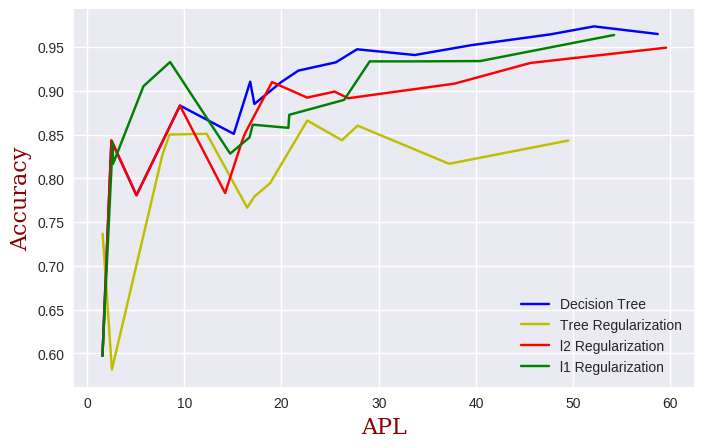

In [66]:
import matplotlib.pyplot as plt
drawtest()